In [24]:
#----------------------------------------------
# Stefano Piacentini - 05/02/2020
#----------------------------------------------

library(rjags)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



In [17]:
rate_sim = function(x,
                    A = 0.,
                    v = 1.,
                    phi = 0. * pi,
                    B = 0.01,
                    SAW = 0) {
    ret <- A * cos(2 * pi * x / v + phi) -SAW * (B*v)/2. + SAW *(B * x) %% (B*v)
    return(ret)
}

In [18]:
# Setting "true values" for simulated data
par_A   <- 0.02 
par_B   <- 0.02
par_Bonlysaw <- 0.04
par_phi <- 0.5 * pi

# Setting errors for simulated data
err   <- 0.01

# Setting number of points of the histogram
N     <- 50

# Setting parameters for unif. priors
B_0       <- 0.02
max_A     <- 0.05
width_B   <- 0.05
max_phi   <- 2*pi

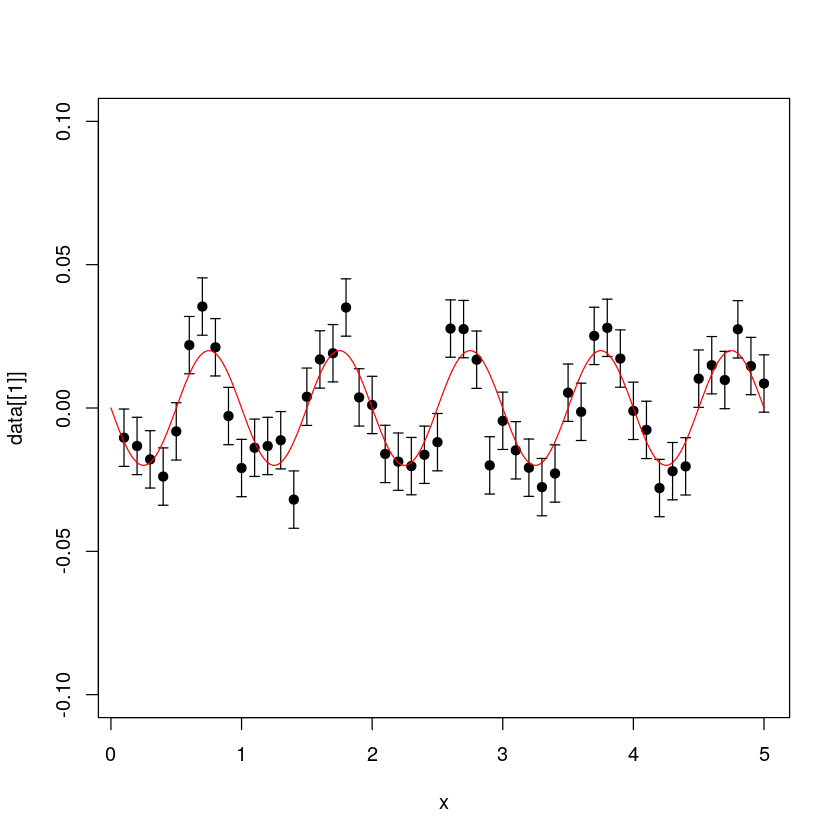

In [19]:
x<-c(1:N)/(N/5)

data <- vector(mode = "list", length = 3)
sddata <- vector(mode = "list", length = 3)

sddata[[1]] <- rep(err, N)
sddata[[2]] <- rep(err, N)
sddata[[3]] <- rep(err, N)

# The first data set is simulated using only cos modulation

tmp <- x
for (i in 1:N) {
    tmp[i] <- rnorm(1,
                     mean = rate_sim(x[i],
                                     SAW = 0,
                                     A = par_A,
                                     phi = par_phi),
                     sd = sddata[[1]][i])
}
data[[1]] <- tmp
plot(x, data[[1]],
    pch=19, ylim = c(-5 * par_A , 5 * par_A)
)
arrows(x, data[[1]]-sddata[[1]], x, data[[1]]+sddata[[1]], length=0.04, angle=90, code=3)

tmp <- seq(0., 5., by = 1e-5)
lines(tmp, rate_sim(tmp, SAW = 0, A = par_A, phi = par_phi), col = 'red')

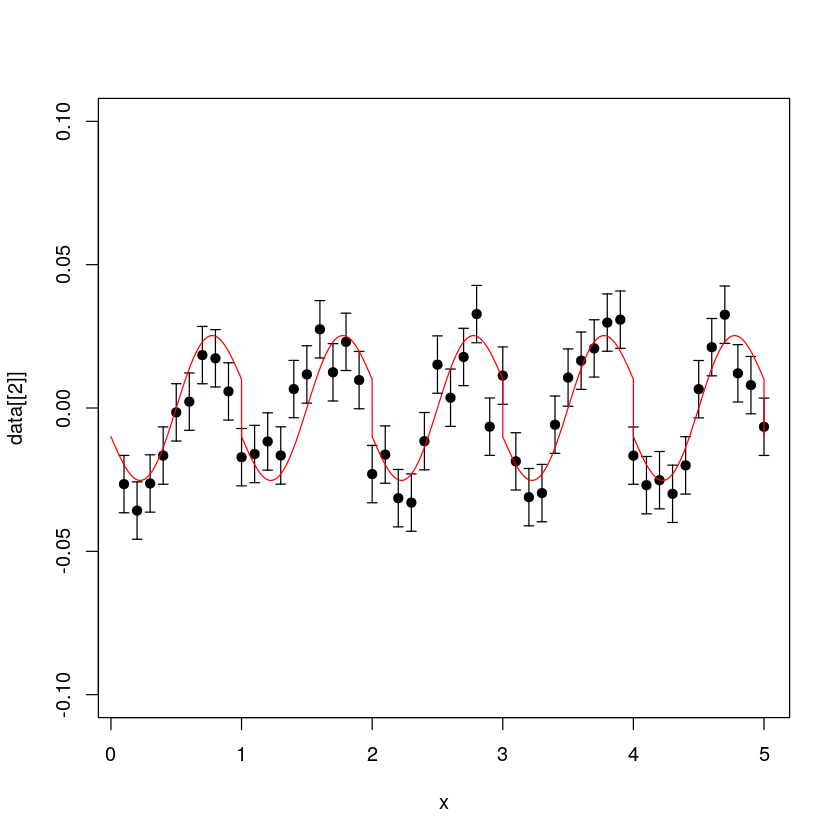

In [20]:
# The second data set is simulated using cos modulation plus sawtooth modulation

tmp <- x
for (i in 1:N) {
    tmp[i] <- rnorm(1,
                      mean = rate_sim(x[i],
                                      SAW = 1,
                                      B = par_B,
                                      A = par_A,
                                      phi = par_phi),
                      sd = sddata[[2]][i])
}
data[[2]] <- tmp
plot(x, data[[2]],
    pch=19, ylim = c(-5.*par_A , 5.*par_A)
)
arrows(x, data[[2]]-sddata[[2]][i], x, data[[2]]+sddata[[2]][i], length=0.04, angle=90, code=3)

tmp <- seq(0., 5., by = 1e-5)
lines(tmp, rate_sim(tmp, SAW = 1, B = par_B, A = par_A, phi = par_phi), col = 'red')

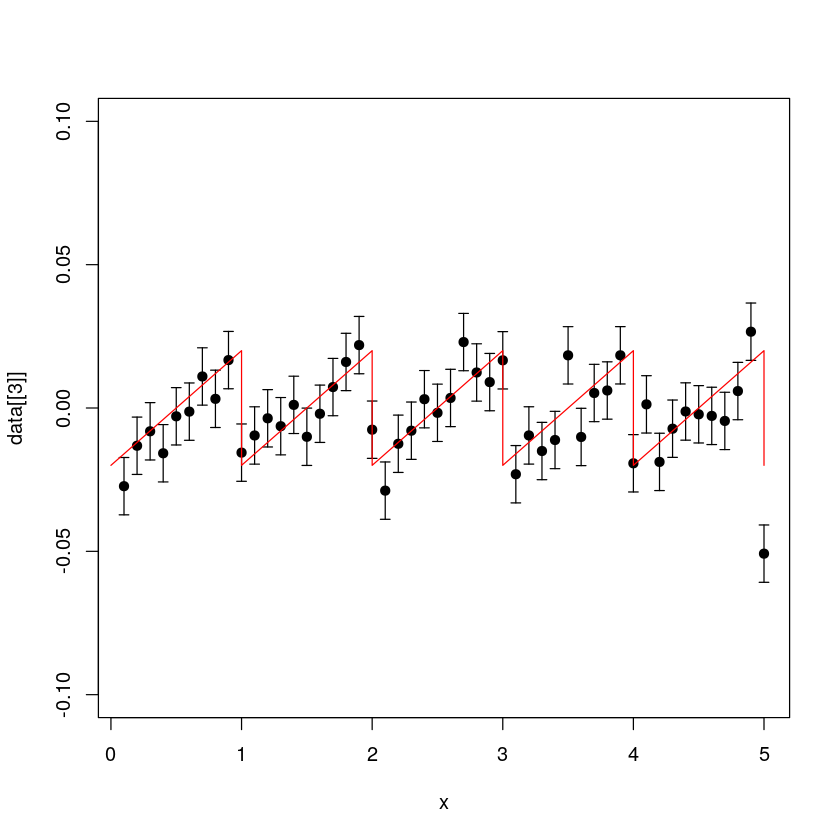

In [21]:
# The second data set is simulated using cos modulation plus sawtooth modulation

tmp <- x
for (i in 1:N) {
    tmp[i] <- rnorm(1,
                      mean = rate_sim(x[i],
                                      SAW = 1,
                                      B = par_Bonlysaw,
                                      A = 0,
                                      phi = 0),
                      sd = sddata[[3]][i])
}
data[[3]] <- tmp
plot(x, data[[3]],
    pch=19, ylim = c(-5.*par_A , 5.*par_A)
)
arrows(x, data[[3]]-sddata[[3]][i], x, data[[3]]+sddata[[3]][i], length=0.04, angle=90, code=3)

tmp <- seq(0., 5., by = 1e-5)
lines(tmp, rate_sim(tmp, SAW = 1, B = par_Bonlysaw, A = 0, phi = 0), col = 'red')

In [22]:
dataframe <- read.table("dama.txt")

N_r <- nrow(dataframe)
t_real <- rep(1, N_r)
ren_t  <- rep(1, N_r)
x_real <- rep(1, N_r)
sd_real <- rep(1, N_r)

for (i in 1:N_r) {
    t_real[i] <- dataframe[i, 1]
    x_real[i] <- dataframe[i, 2]
    
    # dev std media a occhio dai plot
    if (t_real[i]< 5800) {
        sd_real[i] <- 0.015/2
    } else {
        sd_real[i] <- 0.009/2
    }
    
}
ren_t <- (t_real-t_real[1])/365

Warning message in jags.model(modello_cos, fitInput_r, model_cos_init):
“Unused variable "ft" in data”
Warning message in jags.model(modello_cos, fitInput_r, model_cos_init):
“Unused variable "B_0" in data”
Warning message in jags.model(modello_cos, fitInput_r, model_cos_init):
“Unused variable "width_B" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 102
   Unobserved stochastic nodes: 2
   Total graph size: 830

Initializing model


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A   0.009304 0.000762 7.620e-06      9.989e-06
phi 2.273199 0.082376 8.238e-04      1.081e-03

2. Quantiles for each variable:

        2.5%      25%    50%      75%   97.5%
A   0.007845 0.008786 0.0093 0.009815 0.01081
phi 2.113036 2.217939 2.2733 2.329870 2.43548



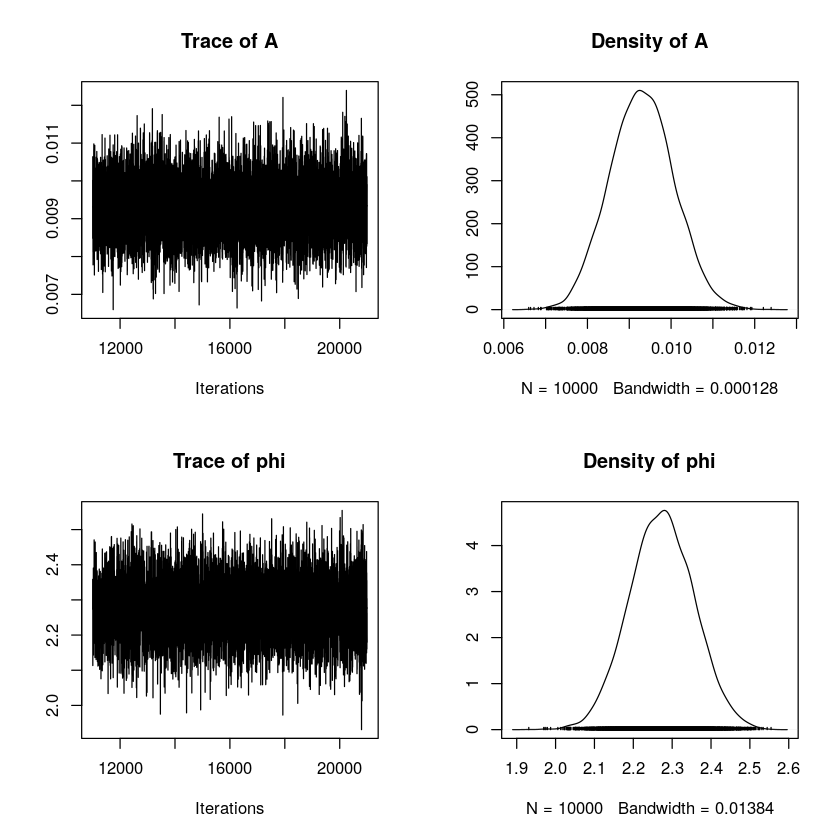

In [26]:
# FIT OF THE REAL DATA WITH COS

modello_cos    <-    "COS.bug" # file con modello di puro segnale

model_cos_init    <- list(A = par_A, phi = par_phi)

fitInput_r <- NULL

fitInput_r$n      <- N_r
fitInput_r$x      <- x_real
fitInput_r$sd     <- sd_real
fitInput_r$t      <- ren_t
fitInput_r$ft     <- floor(x_real)
fitInput_r$v      <- 1
fitInput_r$pi     <- pi
    
# prior parameters
fitInput_r$max_A   <- max_A
fitInput_r$max_phi <- max_phi
fitInput_r$B_0       <- B_0
fitInput_r$width_B   <- width_B

    
m_cos_r <- jags.model(modello_cos,
                    fitInput_r,
                    model_cos_init
                   )

update(m_cos_r, 10000)                  # burn in 

to.sample_cos_r = c('A', 'phi')

catena_cos_r <- coda.samples(m_cos_r, to.sample_cos_r, n.iter=10000)  # sampling 
    
mcmc_cos_r <- as.mcmc(catena_cos_r)

print(summary(catena_cos_r))

plot(catena_cos_r)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 102
   Unobserved stochastic nodes: 3
   Total graph size: 1347

Initializing model


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean        SD  Naive SE Time-series SE
A    9.308e-03 7.755e-04 7.755e-06      9.901e-06
B   -3.917e-05 5.505e-05 5.505e-07      6.781e-07
phi  2.274e+00 8.192e-02 8.192e-04      1.052e-03

2. Quantiles for each variable:

          2.5%        25%        50%        75%     97.5%
A    0.0078032  8.771e-03  9.318e-03  9.844e-03 1.081e-02
B   -0.0001478 -7.608e-05 -3.867e-05 -1.389e-06 6.563e-05
phi  2.1132199  2.219e+00  2.274e+00  2.329e+00 2.435e+00



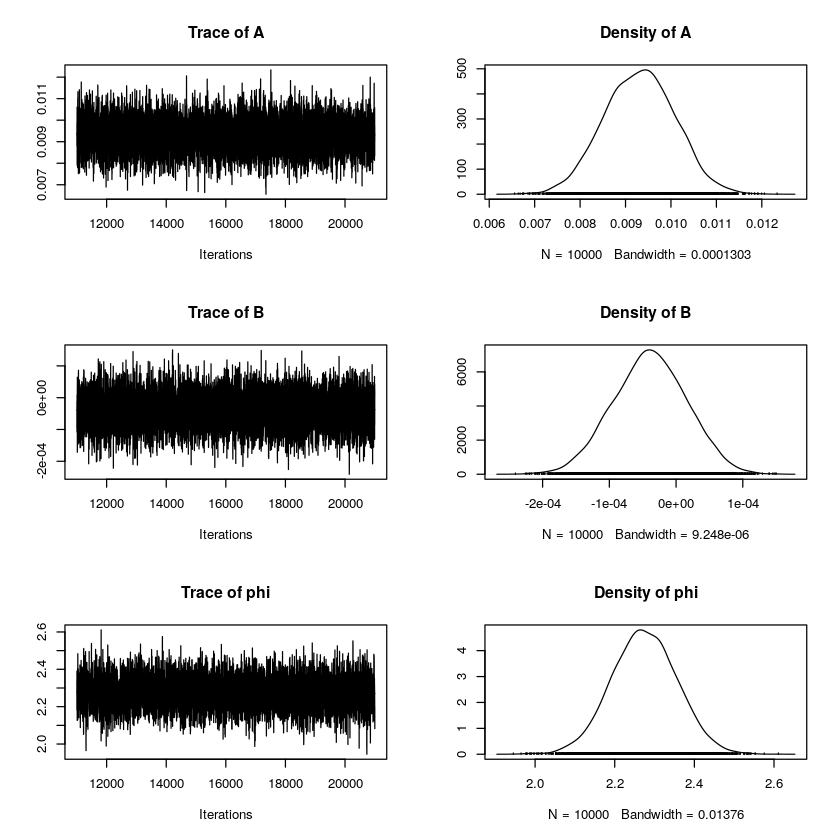

In [28]:
# FIT OF THE REAL DATA WITH SAWCOS

modello_saw    <-    "SAWCOS.bug" # file con modello di puro segnale

model_saw_init    <- list(A = par_A, B = par_B, phi = par_phi)

fitInput_r <- NULL

fitInput_r$n      <- N_r
fitInput_r$x      <- x_real
fitInput_r$sd     <- sd_real
fitInput_r$t      <- ren_t
fitInput_r$ft     <- floor(x_real)
fitInput_r$v      <- 1
fitInput_r$pi     <- pi
    
# prior parameters
fitInput_r$max_A   <- max_A
fitInput_r$max_phi <- max_phi
fitInput_r$B_0       <- B_0
fitInput_r$width_B   <- width_B

    
m_saw_r <- jags.model(modello_saw,
                    fitInput_r,
                    model_saw_init
                   )

update(m_saw_r, 10000)                  # burn in 

to.sample_saw_r = c('A', 'B', 'phi')

catena_saw_r <- coda.samples(m_saw_r, to.sample_saw_r, n.iter=10000)  # sampling 
    
mcmc_saw_r <- as.mcmc(catena_saw_r)

print(summary(catena_saw_r))

plot(catena_saw_r)

In [52]:
# First rough extimations of odds factors

    l_cos_r <- 1
    for (j in 1:N_r) {
        l_cos_r <- l_cos_r * dnorm(x_real[j],
                                         mean = rate_sim(x_real[j],
                                                         SAW = 0,
                                                         A   = mean(mcmc_cos_r[,"A"]),
                                                         phi = mean(mcmc_cos_r[,"phi"])),
                                         sd = sd_real[j])
    }
    l_saw_r <- 1
    for (j in 1:N_r) {
        l_saw_r <- l_saw_r * dnorm(x_real[j],
                                         mean = rate_sim(x_real[j],
                                                         SAW = 1,
                                                         A   = mean(mcmc_saw_r[,"A"]),
                                                         phi = mean(mcmc_saw_r[,"phi"]),
                                                         B   = mean(mcmc_saw_r[,"B"])),
                                         sd = sd_real[j])
    }
    
   
    
    ock_cos_r <- sqrt(2*pi)^(2)*sd(mcmc_cos_r[,"A"])*
                                   sd(mcmc_cos_r[,"phi"])/(max_A * max_phi);
    
    ock_saw_r <- sqrt(2*pi)^(3)*sd(mcmc_saw_r[,"A"])*
                                   sd(mcmc_saw_r[,"B"])*
                                   sd(mcmc_saw_r[,"phi"])/(max_A * (2*width_B) * max_phi);
    
    
    O12_r <- (l_cos_r * ock_cos_r)/(l_saw_r*ock_saw_r);
    O21_r <- 1/O12_r

In [53]:
# Odds ratios for data generated from cos modulations
O12_r
O21_r

[1] 550.3817

[1] 0.001816921

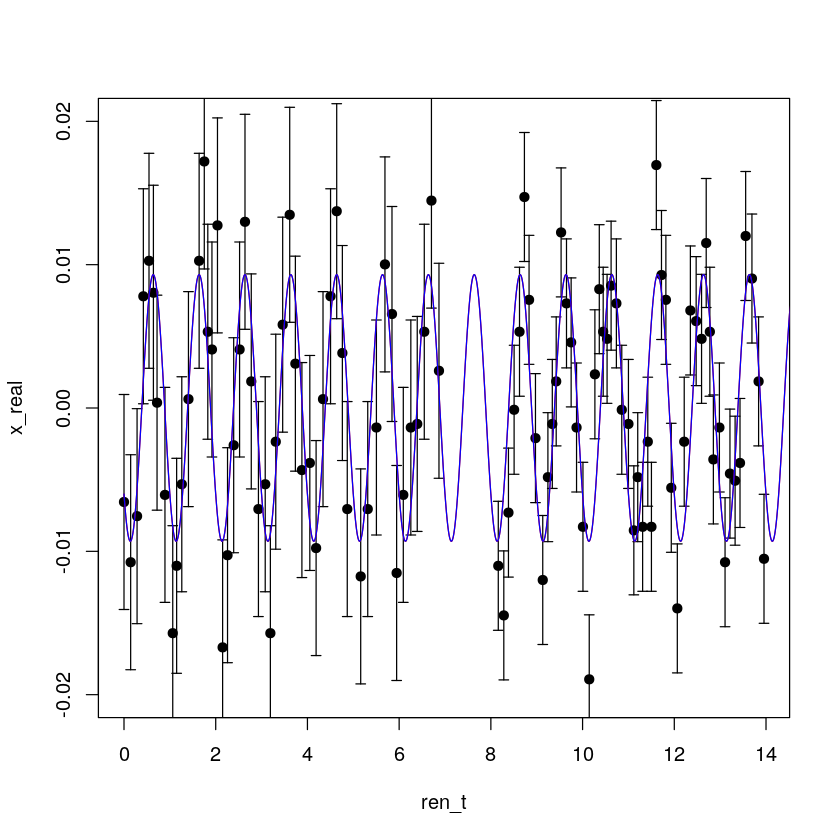

In [57]:
plot(ren_t, x_real,
    pch=19, ylim = c(-1 * par_A , 1 * par_A)
)
arrows(ren_t, x_real-sd_real, ren_t, x_real+sd_real, length=0.04, angle=90, code=3)

tmp <- seq(0., 15., by = 1e-3)
lines(tmp, rate_sim(tmp, SAW = 0,
                    A   = mean(mcmc_cos_r[,"A"]),
                    phi = mean(mcmc_cos_r[,"phi"])
                   ), col = 'red')
lines(tmp, rate_sim(tmp, SAW = 1,
                    A   = mean(mcmc_saw_r[,"A"]),
                    phi = mean(mcmc_saw_r[,"phi"]),
                    B   = mean(mcmc_saw_r[,"B"])
                   ), col = 'blue')

In [75]:
modello_cos    <-    "COS.bug" # file con modello di puro segnale

model_cos_init    <- list(A = par_A, phi = par_phi)

catena_cos <- vector(mode = "list", length = 3)
mcmc_cos <- vector(mode = "list", length = 3)
fitInput <- vector(mode = "list", length = 3)

for (i in 1:3) {

    fitInput[[i]]$n      <- N
    fitInput[[i]]$x      <- data[[i]]
    fitInput[[i]]$sd     <- sddata[[i]]
    fitInput[[i]]$t      <- x
    fitInput[[i]]$ft    <- floor(x)
    fitInput[[i]]$v      <- 1
    fitInput[[i]]$pi     <- pi
    
    # prior parameters
    fitInput[[i]]$max_A   <- max_A
    fitInput[[i]]$max_phi <- max_phi
    fitInput[[i]]$B_0       <- B_0
    fitInput[[i]]$width_B   <- width_B

    
    m_cos <- jags.model(modello_cos,
                    fitInput[[i]],
                    model_cos_init
                   )

    update(m_cos, 10000)                  # burn in 

    to.sample_cos = c('A', 'phi')

    catena_cos[[i]] <- coda.samples(m_cos, to.sample_cos, n.iter=10000)  # sampling 
    
    mcmc_cos[[i]] <- as.mcmc(catena_cos[[i]])
}

Warning message in jags.model(modello_cos, fitInput[[i]], model_cos_init):
“Unused variable "ft" in data”
Warning message in jags.model(modello_cos, fitInput[[i]], model_cos_init):
“Unused variable "B_0" in data”
Warning message in jags.model(modello_cos, fitInput[[i]], model_cos_init):
“Unused variable "width_B" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 50
   Unobserved stochastic nodes: 2
   Total graph size: 412

Initializing model



Warning message in jags.model(modello_cos, fitInput[[i]], model_cos_init):
“Unused variable "ft" in data”
Warning message in jags.model(modello_cos, fitInput[[i]], model_cos_init):
“Unused variable "B_0" in data”
Warning message in jags.model(modello_cos, fitInput[[i]], model_cos_init):
“Unused variable "width_B" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 50
   Unobserved stochastic nodes: 2
   Total graph size: 412

Initializing model



Warning message in jags.model(modello_cos, fitInput[[i]], model_cos_init):
“Unused variable "ft" in data”
Warning message in jags.model(modello_cos, fitInput[[i]], model_cos_init):
“Unused variable "B_0" in data”
Warning message in jags.model(modello_cos, fitInput[[i]], model_cos_init):
“Unused variable "width_B" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 50
   Unobserved stochastic nodes: 2
   Total graph size: 412

Initializing model




Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A   0.01975 0.002011 2.011e-05      2.587e-05
phi 1.67775 0.102841 1.028e-03      1.381e-03

2. Quantiles for each variable:

       2.5%     25%     50%    75%   97.5%
A   0.01586 0.01838 0.01976 0.0211 0.02366
phi 1.47496 1.61050 1.67765 1.7457 1.88110



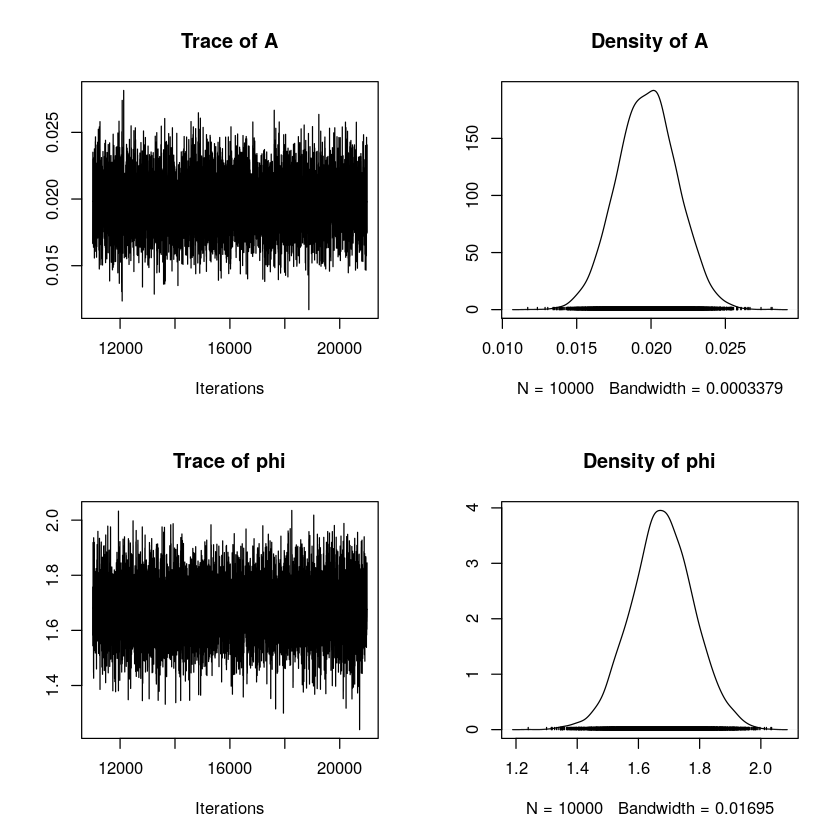

In [76]:
# Results of the first fit for the first data set

print(summary(catena_cos[[1]]))
plot(catena_cos[[1]])


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A   0.02367 0.001998 1.998e-05      0.0000254
phi 1.61226 0.085418 8.542e-04      0.0011448

2. Quantiles for each variable:

       2.5%    25%     50%     75%   97.5%
A   0.01976 0.0223 0.02368 0.02504 0.02761
phi 1.44759 1.5551 1.61223 1.66831 1.78102



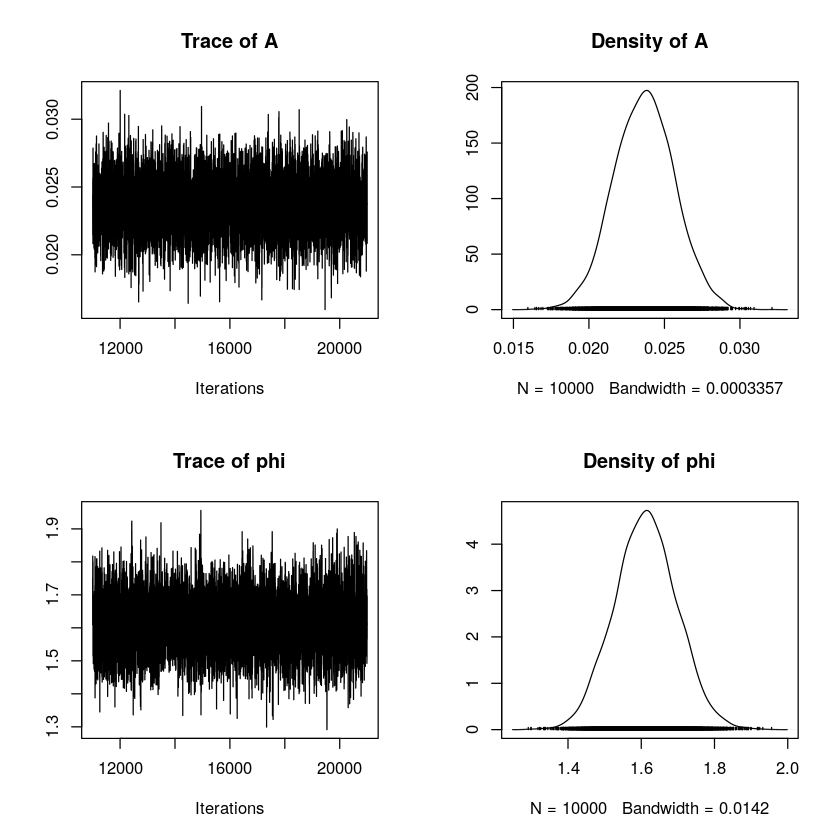

In [77]:
# Results of the first fit for the second data set

print(summary(catena_cos[[2]]))
plot(catena_cos[[2]])


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A   0.01837 0.002007 2.007e-05      2.565e-05
phi 1.67560 0.112232 1.122e-03      1.426e-03

2. Quantiles for each variable:

       2.5%   25%     50%     75%   97.5%
A   0.01445 0.017 0.01835 0.01972 0.02227
phi 1.45255 1.601 1.67706 1.75227 1.89161



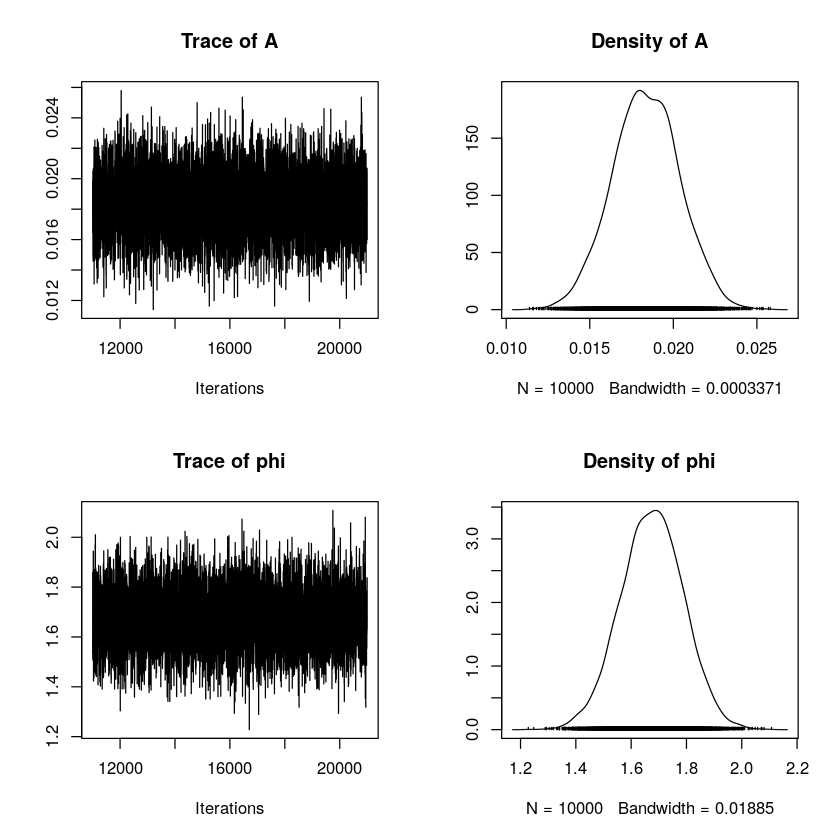

In [78]:
# Results of the first fit for the third data set

print(summary(catena_cos[[3]]))
plot(catena_cos[[3]])

In [79]:
modello_saw <- "SAWCOS.bug" # file con modello di segnale + rumore lineare

model_saw_init <- list(A = par_A, B = B_0, phi = par_phi)

catena_saw <- vector(mode = "list", length = 3)
mcmc_saw <- vector(mode = "list", length = 3)

for (i in 1:3) {

    m_saw <- jags.model(modello_saw,
                    fitInput[[i]],
                    model_saw_init
                   )

    update(m_saw, 10000)                  # burn in 

    to.sample_saw = c('A', 'B', 'phi')

    catena_saw[[i]] <- coda.samples(m_saw, to.sample_saw, n.iter=10000)  # sampling 
    
    mcmc_saw[[i]] <- as.mcmc(catena_saw[[i]])
}

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 50
   Unobserved stochastic nodes: 3
   Total graph size: 590

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 50
   Unobserved stochastic nodes: 3
   Total graph size: 590

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 50
   Unobserved stochastic nodes: 3
   Total graph size: 590

Initializing model




Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
A   0.017589 0.003156 3.156e-05      8.182e-05
B   0.006841 0.007883 7.883e-05      2.051e-04
phi 1.651090 0.124910 1.249e-03      1.883e-03

2. Quantiles for each variable:

         2.5%      25%      50%     75%   97.5%
A    0.011505 0.015427 0.017606 0.01977 0.02376
B   -0.008444 0.001333 0.006757 0.01233 0.02218
phi  1.392698 1.571649 1.656029 1.73736 1.88110



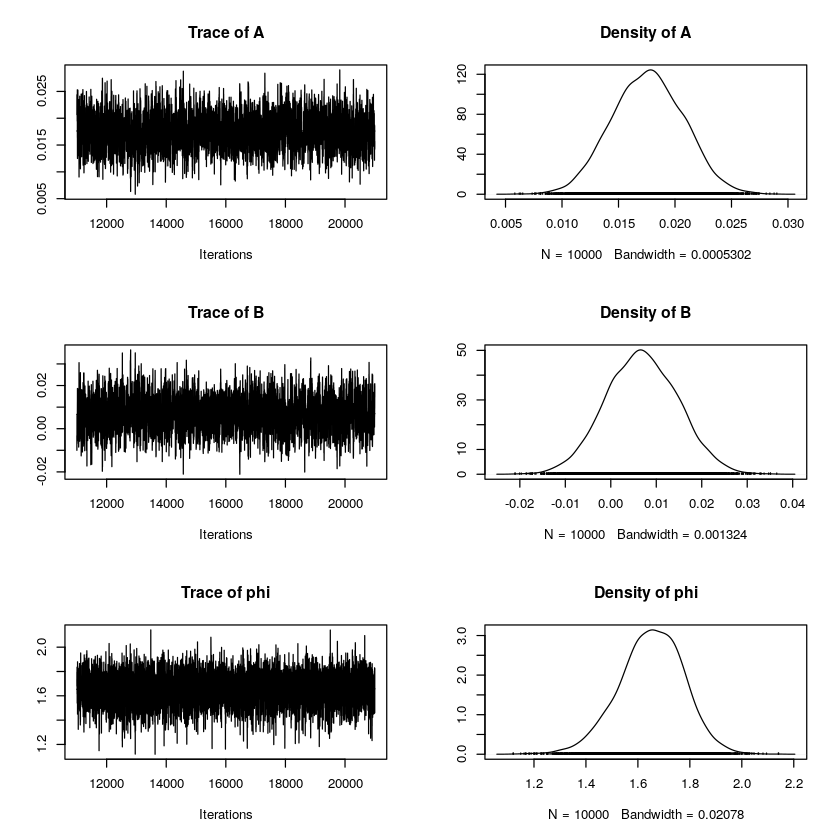

In [80]:
# Results of the second fit for the first data set

print(summary(catena_saw[[1]]))
plot(catena_saw[[1]])


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A   0.01686 0.003090 3.090e-05      7.762e-05
B   0.02216 0.007889 7.889e-05      2.060e-04
phi 1.48790 0.141517 1.415e-03      2.714e-03

2. Quantiles for each variable:

        2.5%     25%     50%     75%   97.5%
A   0.010768 0.01477 0.01688 0.01896 0.02287
B   0.006908 0.01674 0.02212 0.02741 0.03761
phi 1.182701 1.40235 1.49800 1.58505 1.74064



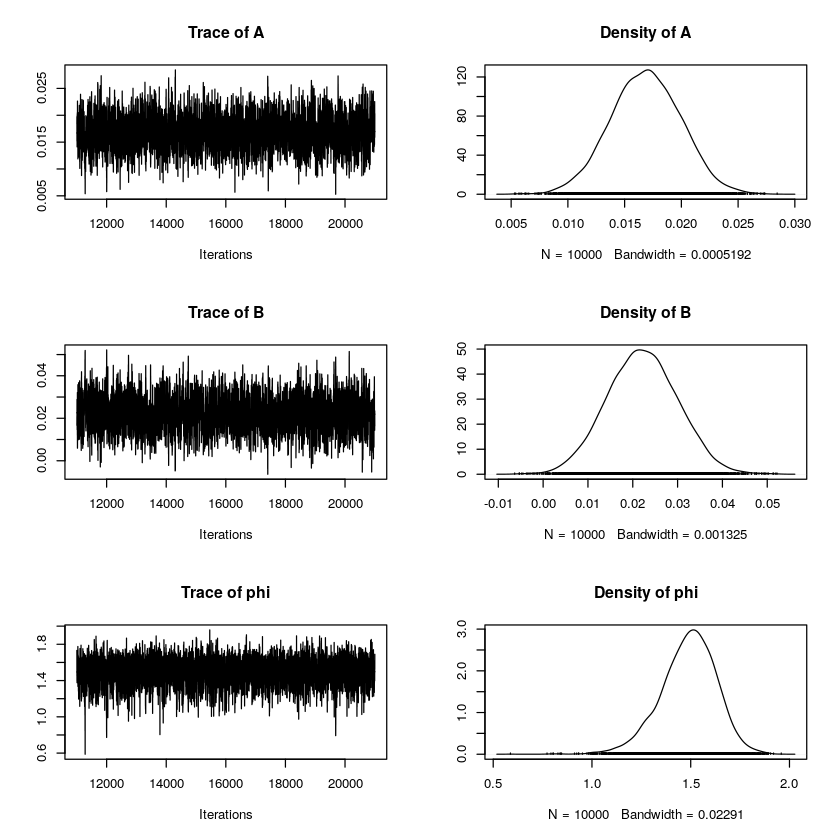

In [81]:
# Results of the second fit for the second data set

print(summary(catena_saw[[2]]))
plot(catena_saw[[2]])


Iterations = 11001:21000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A   0.00718 0.003001 3.001e-05      7.948e-05
B   0.03633 0.007895 7.895e-05      2.151e-04
phi 1.37708 0.683296 6.833e-03      4.576e-02

2. Quantiles for each variable:

        2.5%      25%      50%      75%   97.5%
A   0.001431 0.005122 0.007108 0.009159 0.01331
B   0.020586 0.031022 0.036408 0.041819 0.05113
phi 0.430894 1.099080 1.356279 1.562394 2.17906



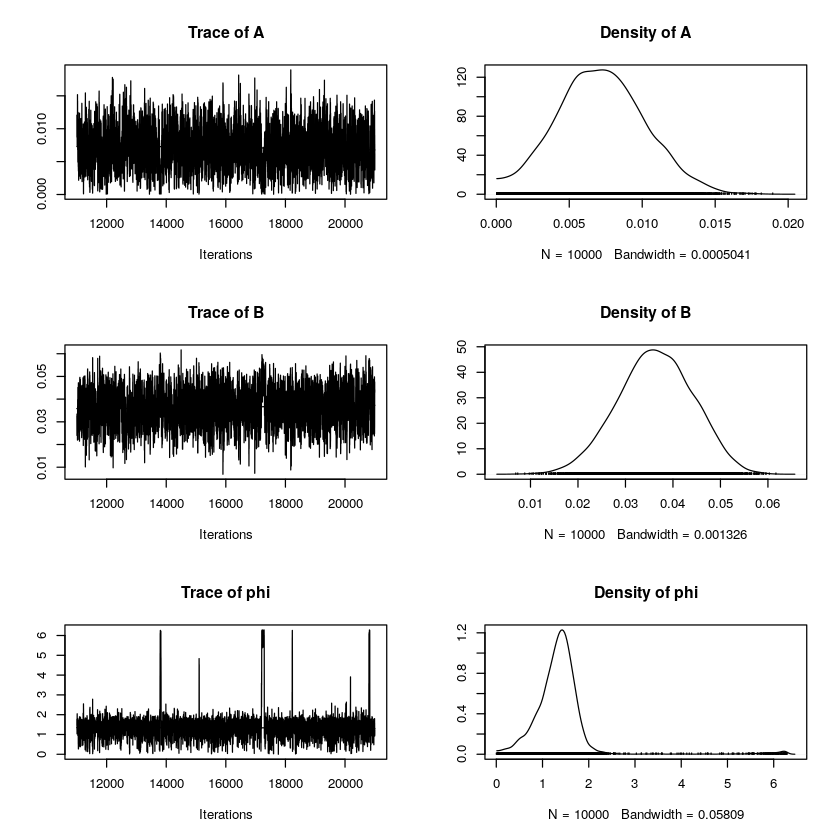

In [82]:
# Results of the second fit for the third data set

print(summary(catena_saw[[3]]))
plot(catena_saw[[3]])

In [83]:
# transform the chain in a dataframe
saw.df <- as.data.frame( mcmc_saw[[1]] )

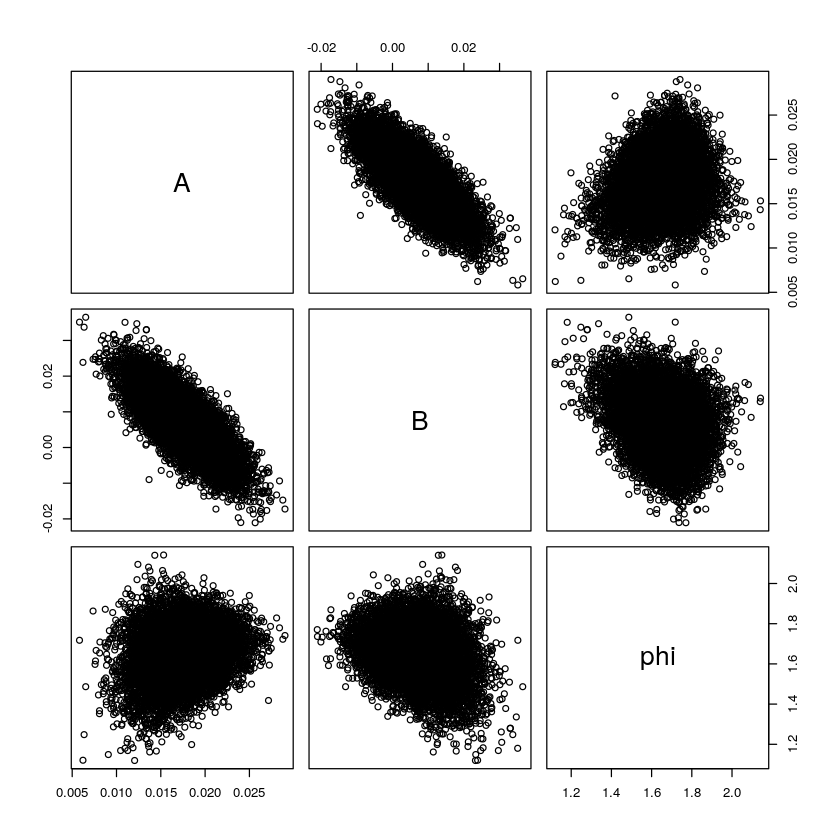

In [84]:
plot(saw.df)

In [85]:
cor(saw.df$A, saw.df$phi)

[1] 0.2090039

In [86]:
# First rough extimations of odds factors

l_cos <- vector(mode = "list", length = 3)
l_saw <- vector(mode = "list", length = 3)
ock_cos <- vector(mode = "list", length = 3)
ock_saw <- vector(mode = "list", length = 3)

O12 <- vector(mode = "list", length = 3)
O21 <- vector(mode = "list", length = 3)

for (i in 1:3) {
    l_cos[[i]] <- 1
    for (j in 1:N) {
        l_cos[[i]] <- l_cos[[i]] * dnorm(data[[i]][j],
                                         mean = rate_sim(x[j],
                                                         SAW = 0,
                                                         A   = mean(mcmc_cos[[i]][,"A"]),
                                                         phi = mean(mcmc_cos[[i]][,"phi"])),
                                         sd = sddata[[i]][j])
    }
    l_saw[[i]] <- 1
    for (j in 1:N) {
        l_saw[[i]] <- l_saw[[i]] * dnorm(data[[i]][j],
                                         mean = rate_sim(x[j],
                                                         SAW = 1,
                                                         A   = mean(mcmc_saw[[i]][,"A"]),
                                                         phi = mean(mcmc_saw[[i]][,"phi"]),
                                                         B   = mean(mcmc_saw[[i]][,"B"])),
                                         sd = sddata[[i]][j])
    }
    
   
    
    ock_cos[[i]] <- sqrt(2*pi)^(2)*sd(mcmc_cos[[i]][,"A"])*
                                   sd(mcmc_cos[[i]][,"phi"])/(max_A * max_phi);
    
    ock_saw[[i]] <- sqrt(2*pi)^(3)*sd(mcmc_saw[[i]][,"A"])*
                                   sd(mcmc_saw[[i]][,"B"])*
                                   sd(mcmc_saw[[i]][,"phi"])/(max_A * (2*width_B) * max_phi);
    
    
    O12[[i]] <- (l_cos[[i]] * ock_cos[[i]])/(l_saw[[i]]*ock_saw[[i]]);
    O21[[i]] <- 1/O12[[i]]
}

In [87]:
# Odds ratios for data generated from cos modulations
O12[[1]]
O21[[1]]

[1] 1.315459

[1] 0.760191

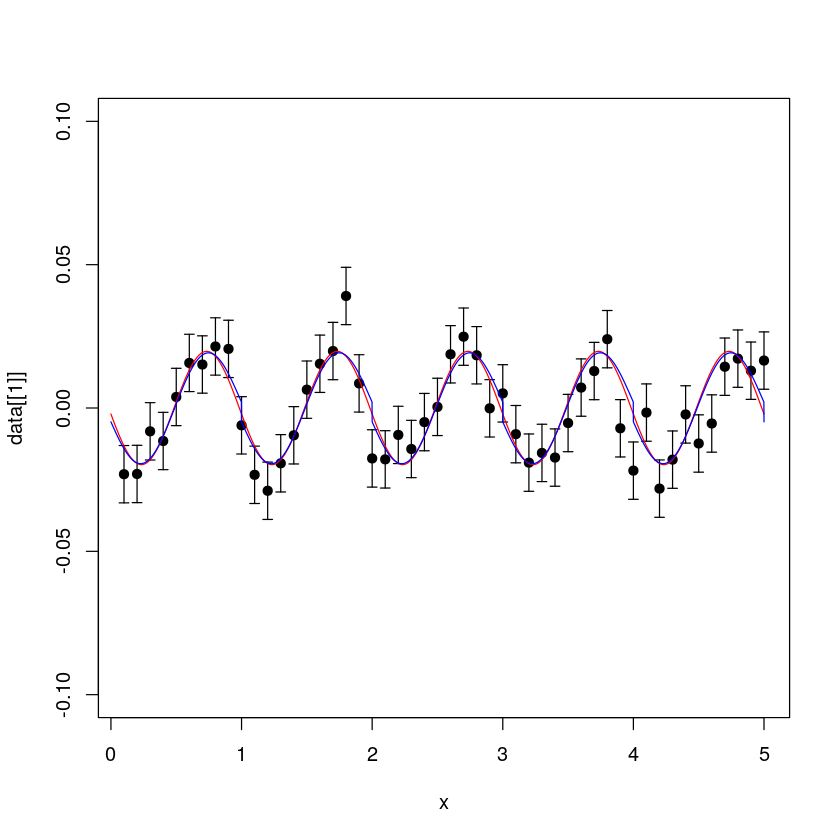

In [88]:
plot(x, data[[1]],
    pch=19, ylim = c(-5 * par_A , 5 * par_A)
)
arrows(x, data[[1]]-sddata[[1]], x, data[[1]]+sddata[[1]], length=0.04, angle=90, code=3)

tmp <- seq(0., 5., by = 1e-3)
lines(tmp, rate_sim(tmp, SAW = 0,
                    A   = mean(mcmc_cos[[1]][,"A"]),
                    phi = mean(mcmc_cos[[1]][,"phi"])
                   ), col = 'red')
lines(tmp, rate_sim(tmp, SAW = 1,
                    A   = mean(mcmc_saw[[1]][,"A"]),
                    phi = mean(mcmc_saw[[1]][,"phi"]),
                    B   = mean(mcmc_saw[[1]][,"B"])
                   ), col = 'blue')

In [89]:
# Odds ratios for data generated from cos+sawtooth modulations
O12[[2]]
O21[[2]]

[1] 0.05622565

[1] 17.78548

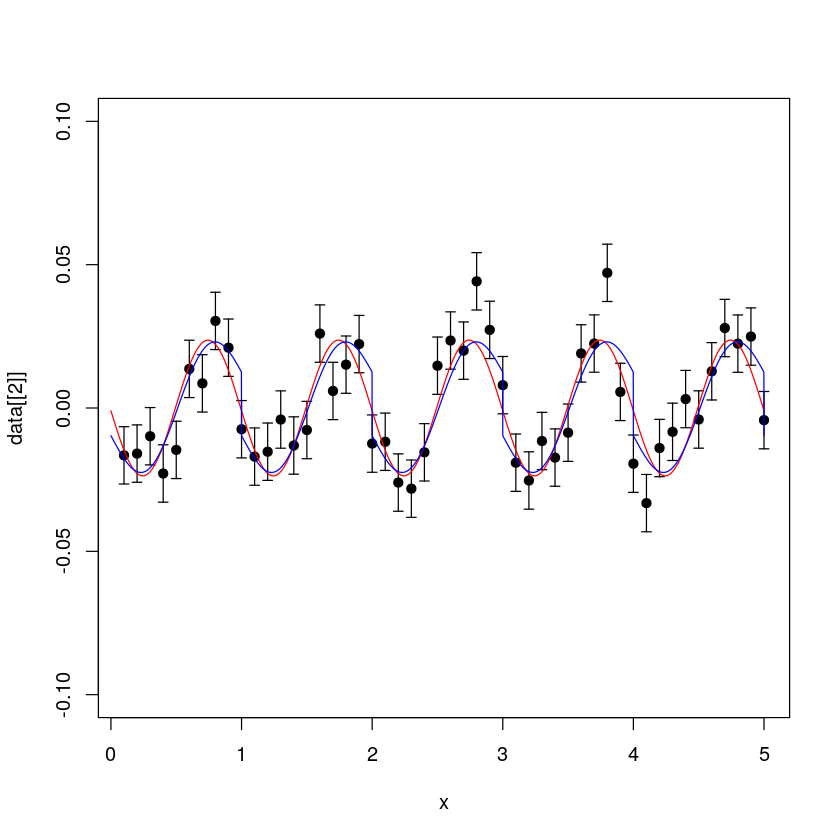

In [90]:
plot(x, data[[2]],
    pch=19, ylim = c(-5 * par_A , 5 * par_A)
)
arrows(x, data[[2]]-sddata[[2]], x, data[[2]]+sddata[[2]], length=0.04, angle=90, code=3)

tmp <- seq(0., 5., by = 1e-3)
lines(tmp, rate_sim(tmp, SAW = 0,
                    A   = mean(mcmc_cos[[2]][,"A"]),
                    phi = mean(mcmc_cos[[2]][,"phi"])
                   ), col = 'red')
lines(tmp, rate_sim(tmp, SAW = 1,
                    A   = mean(mcmc_saw[[2]][,"A"]),
                    phi = mean(mcmc_saw[[2]][,"phi"]),
                    B   = mean(mcmc_saw[[2]][,"B"])
                   ), col = 'blue')

In [91]:
# Odds ratios for data generated from cos+sawtooth modulations
O12[[3]]
O21[[3]]

[1] 0.005236969

[1] 190.9502

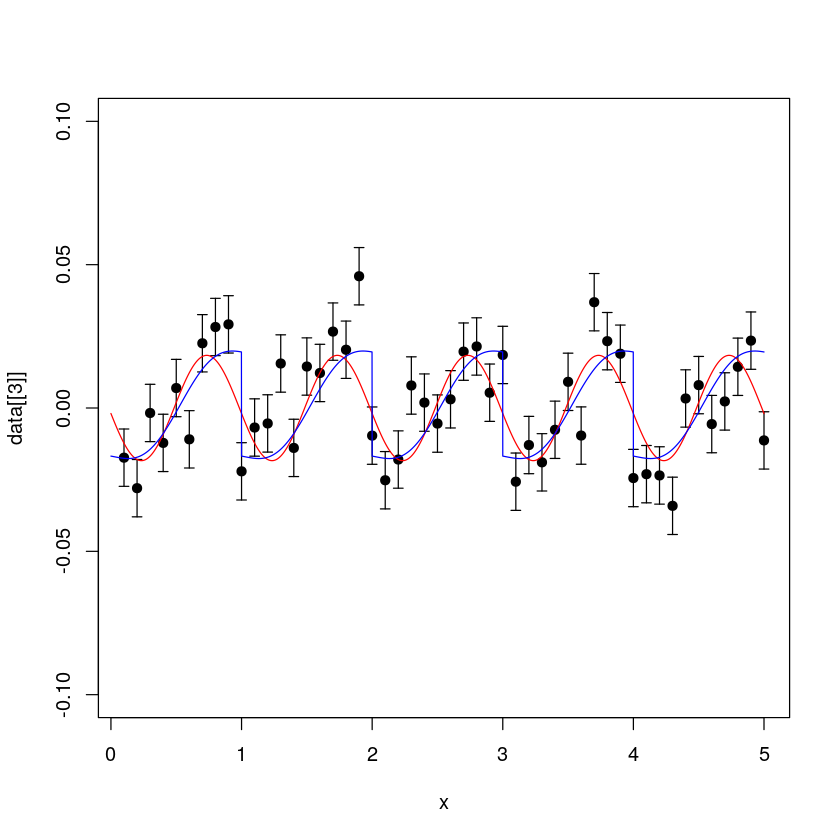

In [92]:
plot(x, data[[3]],
    pch=19, ylim = c(-5 * par_A , 5 * par_A)
)
arrows(x, data[[3]]-sddata[[3]], x, data[[3]]+sddata[[3]], length=0.04, angle=90, code=3)

tmp <- seq(0., 5., by = 1e-3)
lines(tmp, rate_sim(tmp, SAW = 0,
                    A   = mean(mcmc_cos[[3]][,"A"]),
                    phi = mean(mcmc_cos[[3]][,"phi"])
                   ), col = 'red')
lines(tmp, rate_sim(tmp, SAW = 1,
                    A   = mean(mcmc_saw[[3]][,"A"]),
                    phi = mean(mcmc_saw[[3]][,"phi"]),
                    B   = mean(mcmc_saw[[3]][,"B"])
                   ), col = 'blue')

In [93]:
library(bridgesampling)
library(R2jags)
library(mcmcplots)

In [94]:
### functions for evaluating the unnormalized posteriors on log scale ###


log_posterior_cos <- function(pars, data) {
      
      
  A   <- pars["A"]
  phi <- pars["phi"]

    
  sig <- A * cos(2. * pi * data$t / data$v + phi )


  out <-
      dunif(A, 0.0, data$max_A, log = TRUE) +          # prior
      dunif(phi, 0.0, data$max_phi, log = TRUE) +      # prior
      sum(dnorm(data$x, sig, data$sd, log = TRUE))       # likelihood

 return(out)  
}



In [95]:
### functions for evaluating the unnormalized posteriors on log scale ###


log_posterior_saw <- function(pars, data) {
      
      
  A   <- pars["A"]
  B   <- pars["B"]
  phi <- pars["phi"]

    
  sig <- A * cos(2. * pi * data$t / data$v + phi )
  bkg <- -(B*data$v)/2. + (B * data$t) %% (B*data$v)

    out <-
      dunif(A, 0.0, data$max_A, log = TRUE) +          # prior
      dunif(B, data$B_0 - data$width_B, data$B_0 + data$width_B, log = TRUE) +          # prior
      dunif(phi, 0.0, data$max_phi, log = TRUE) +      # prior
      sum(dnorm(data$x, sig+bkg, data$sd, log = TRUE))       # likelihood

 return(out)  
}

In [96]:
# specify parameter bounds for cos
cn <- c("A", "phi")
lb_cos <- rep(0, length(cn))
ub_cos <- rep(0, length(cn))
names(lb_cos) <- names(ub_cos) <- cn
lb_cos["phi"] = 0.0
ub_cos["phi"] = fitInput[[1]]$max_phi
lb_cos["A"] = 0.0 
ub_cos["A"] = fitInput[[1]]$max_A


In [97]:
# specify parameter bounds for cos
cn <- c("A", "B", "phi")
lb_saw <- rep(0, length(cn))
ub_saw <- rep(0, length(cn))
names(lb_saw) <- names(ub_saw) <- cn
lb_saw["phi"] = 0.0
ub_saw["phi"] = fitInput[[1]]$max_phi
lb_saw["A"] = 0.0 
ub_saw["A"] = fitInput[[1]]$max_A
lb_saw["B"] = fitInput[[1]]$B_0 - fitInput[[1]]$width_B 
ub_saw["B"] = fitInput[[1]]$B_0 + fitInput[[1]]$width_B 


In [99]:
# compute log marginal likelihood via bridge sampling for H0
cos.bridge <- bridge_sampler(samples = catena_cos[[3]], data = fitInput[[3]],
                            log_posterior = log_posterior_cos, lb = lb_cos,
                            ub = ub_cos, silent = TRUE, verbose = TRUE, maxiter = 300)



[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -6.698   1.887   2.620   2.294   3.032   3.311 
[1] "summary(q22): (log_dens of proposal (i.e., with dmvnorm) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -6.622   1.960   2.619   2.321   3.027   3.311 

[1] "summary(q11): (log_dens of posterior (i.e., with log_posterior) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  126.3   133.0   133.8   133.5   134.2   134.5 
[1] "summary(q21): (log_dens of posterior (i.e., with log_posterior) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  123.1   133.1   133.8   133.5   134.2   134.5 



In [100]:
# compute log marginal likelihood via bridge sampling for H0
saw.bridge <- bridge_sampler(samples = catena_saw[[3]], data = fitInput[[3]],
                            log_posterior = log_posterior_saw, lb = lb_saw,
                            ub = ub_saw, silent = TRUE, verbose = TRUE, maxiter = 300)




[1] "summary(q12): (log_dens of proposal (i.e., with dmvnorm) for posterior samples)"
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-125.4627   -0.1155    0.6625   -1.0985    1.0511    1.4021 
[1] "summary(q22): (log_dens of proposal (i.e., with dmvnorm) for generated samples)"
[[1]]
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-7.88542 -0.66195  0.23532 -0.09017  0.80735  1.40149 

[1] "summary(q11): (log_dens of posterior (i.e., with log_posterior) for posterior samples)"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  125.1   138.0   140.9   140.2   142.1   148.6 
[1] "summary(q21): (log_dens of posterior (i.e., with log_posterior) for generated samples)"
[[1]]
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   72.0   135.0   138.5   137.7   141.0   148.6 



In [101]:
print(saw.bridge)

Bridge sampling estimate of the log marginal likelihood: 141.4149
Estimate obtained in 54 iteration(s) via method "normal".


In [102]:
error_measures(saw.bridge)

$re2
[1] 0.000582005

$cv
[1] 0.02412478

$percentage
[1] "2%"

In [103]:
print(cos.bridge)

Bridge sampling estimate of the log marginal likelihood: 131.1538
Estimate obtained in 4 iteration(s) via method "normal".


In [104]:
error_measures(cos.bridge)

$re2
[1] 5.467396e-07

$cv
[1] 0.0007394184

$percentage
[1] "0%"

In [105]:
BF01 <- bf(cos.bridge, saw.bridge)
print(BF01)

Estimated Bayes factor in favor of cos.bridge over saw.bridge: 0.00003


In [106]:
post <- post_prob(cos.bridge, saw.bridge)
print(post)

  cos.bridge   saw.bridge 
3.496529e-05 9.999650e-01 
